In [1]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
from astropy.constants import G
import matplotlib as mpl
import sys
from scipy import interpolate
from scipy.integrate import simps
import osyris
from matplotlib import colors 

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist
from pipeline_2D import to_osyris_ivs


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

Initialising patch data


100%|██████████| 4165/4165 [00:21<00:00, 197.43it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 8739.18it/s] 


Disk size: 17.9 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 4972.28it/s]


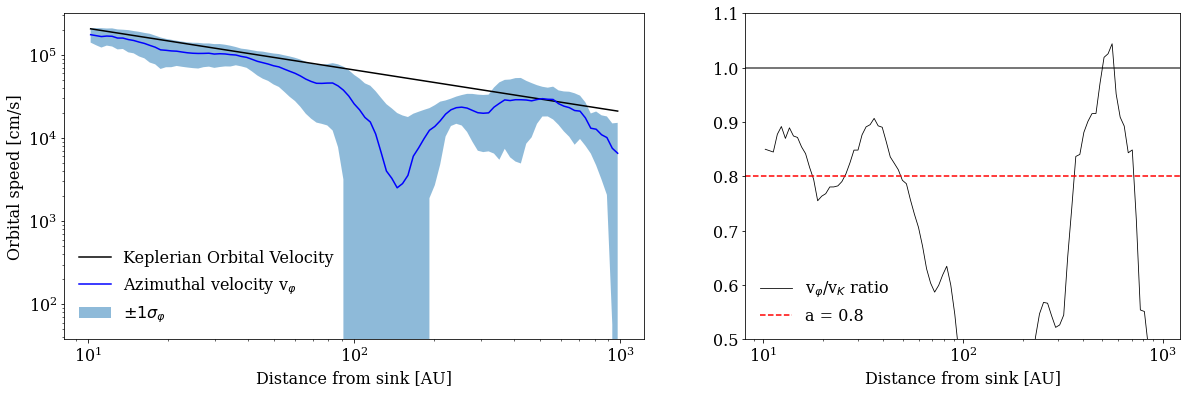

In [2]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 
data.calc_disksize()
data.calc_trans_xyz()

# Trying to figure out a way to sample the total angular momentum in a better and more correct way
# $$L = \int\int dr d\phi\;r^3 \omega(r)\Sigma(r) $$

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/1376 [00:00<?, ?it/s]

100%|██████████| 1376/1376 [00:05<00:00, 248.58it/s]


Setting up Osyris data structure
24.264427773680247


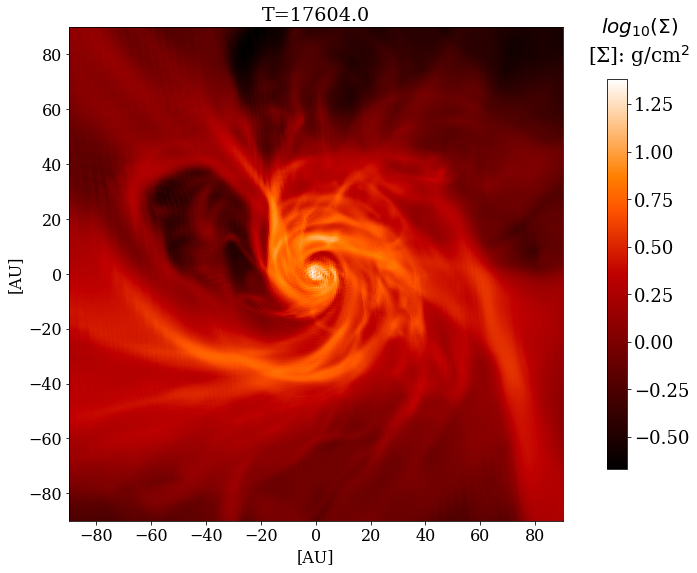

In [3]:
radius = 90
height = radius
variable = ['d']
view = 2 * radius 
data.to_osyris_ivs(variables=variable, view = view, dz = 2*height, resolution = 600)#height * data.au_length)#, dz = view, viewpoint=np.cross(data_13n.L, np.array([0,0,1])))

extent = view // 2
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10(data.osyris_ivs[0] * data.cgs_density), extent = (-extent, extent, -extent, extent), origin ='lower', cmap = 'gist_heat')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = f'T={data.time:4.1f}', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)
print((data.osyris_ivs[0] * data.cgs_density).max())

  0%|          | 0/1376 [00:00<?, ?it/s]

100%|██████████| 1376/1376 [00:04<00:00, 319.00it/s]


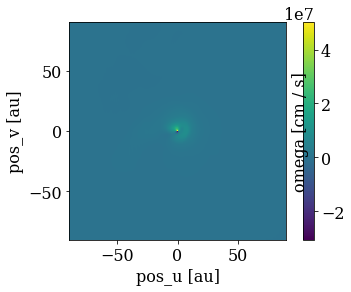

In [4]:
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2
pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]


patch_values = []
patch_densities = []
patch_cartcoor = []
patch_ds = []
for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
    if len(leafs) == 8: continue
    to_extract = np.ones(p.n, dtype=bool)
    for lp in leafs:
        
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool

    new_xyz = p.rel_xyz[:,to_extract].T
    ω = (p.vφ / p.cyl_R)[to_extract].T
    
    patch_ds.extend(p.ds[0] * np.ones(len(ω)))
    patch_cartcoor.extend(new_xyz.tolist())
    patch_values.extend(ω.tolist())
     
patch_ds = np.asarray(patch_ds)
patch_cartcoor = np.asarray(patch_cartcoor)
patch_values = np.asarray(patch_values)

ds = osyris.Dataset(nout = None)
# overwrite units
ds.meta['unit_l'] = data.sn.scaling.l
ds.meta['unit_t'] = data.sn.scaling.t
ds.meta['unit_d'] = data.sn.scaling.d
ds.set_units()
ds.meta["ndim"] = 3

ds['amr'] = osyris.Datagroup()
ds['amr']['dx'] = osyris.Array(patch_ds*data.sn.scaling.l, unit='cm')
ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*data.sn.scaling.l, y=patch_cartcoor[:,1]*data.sn.scaling.l, z=patch_cartcoor[:,2]*data.sn.scaling.l, unit='cm')
ds['hydro'] = osyris.Datagroup()
ds['hydro']['omega'] = osyris.Array(patch_values/data.sn.scaling.t, unit='1/s')

L=osyris.Vector(x=data.L[0],y=data.L[1],z=data.L[2])


plot_height = 90 * data.sn.cgs.au

view = 180 * osyris.units('au')
center = osyris.Vector(x=0,y=0,z=0,unit='au')
ret = osyris.map({"data": ds['hydro']['omega'], "norm": "linear"}, 
                 dx=view, dz = view, origin=center, resolution=600, direction=L, plot=True)

Ω = ret.layers[0]['data'] / plot_height


/tmp/ipykernel_692286/1473361389.py:2: RuntimeWarning: invalid value encountered in log10
  cs = axs.imshow(np.log10(Ω), extent = (-90, 90, -90, 90), origin ='lower', cmap = 'jet')


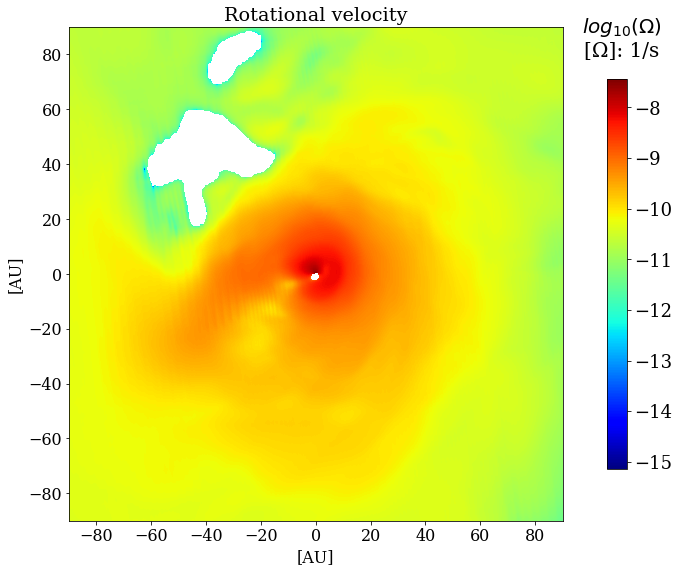

In [5]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10(Ω), extent = (-90, 90, -90, 90), origin ='lower', cmap = 'jet')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(Ω)$\n[Ω]: 1/s', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Rotational velocity', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

# $$L=\int\int dx dy\;r^2 \Sigma(x,y) \omega(x,y)$$

In [6]:
x = np.linspace(-90,90, 600); y =  np.linspace(-90,90, 600)
xx, yy = np.meshgrid(x,y, indexing='ij')

In [7]:
rr = np.sqrt(xx**2 + yy**2)

In [8]:
bool = rr < 90

In [9]:
xx * data.sn.cgs.au 

array([[-1.34640000e+15, -1.34640000e+15, -1.34640000e+15, ...,
        -1.34640000e+15, -1.34640000e+15, -1.34640000e+15],
       [-1.34190451e+15, -1.34190451e+15, -1.34190451e+15, ...,
        -1.34190451e+15, -1.34190451e+15, -1.34190451e+15],
       [-1.33740902e+15, -1.33740902e+15, -1.33740902e+15, ...,
        -1.33740902e+15, -1.33740902e+15, -1.33740902e+15],
       ...,
       [ 1.33740902e+15,  1.33740902e+15,  1.33740902e+15, ...,
         1.33740902e+15,  1.33740902e+15,  1.33740902e+15],
       [ 1.34190451e+15,  1.34190451e+15,  1.34190451e+15, ...,
         1.34190451e+15,  1.34190451e+15,  1.34190451e+15],
       [ 1.34640000e+15,  1.34640000e+15,  1.34640000e+15, ...,
         1.34640000e+15,  1.34640000e+15,  1.34640000e+15]])

In [10]:
Σ = data.osyris_ivs[0] * data.cgs_density
Ω_cut = Ω.copy(); Σ_cut = Σ.copy()
Ω_cut[rr > 90] = 0 
Σ_cut[rr > 90] = 0
simps(simps(Ω_cut * (rr * data.sn.cgs.au)**2 * Σ_cut, x * data.sn.cgs.au, axis = 0), y * data.sn.cgs.au)

7.407447467112219e+50

In [11]:
np.sum(Σ_cut == 0) / 600**2

0.21733333333333332

In [24]:
(-5.484169474981151e+39 / 7.407447467112219e+50) * 1e3 * data.sn.cgs.yr

-0.23361432020376238

In [20]:
data.sn.cgs.yr**(-1)

3.169150224058921e-08

In [17]:
1 * data.sn.cgs.yr

31554200.0

In [18]:
365*24*60*60

31536000